1. Design a process that stays in the interval $[a,b]$ and mean-reverts around $\frac{b-a}{с}$, $c \sim \mathcal{U}(a,b)$.

Generate a path and plot it in graph and add the mean line.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import  ncx2
import pandas as pd

from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.signal import find_peaks

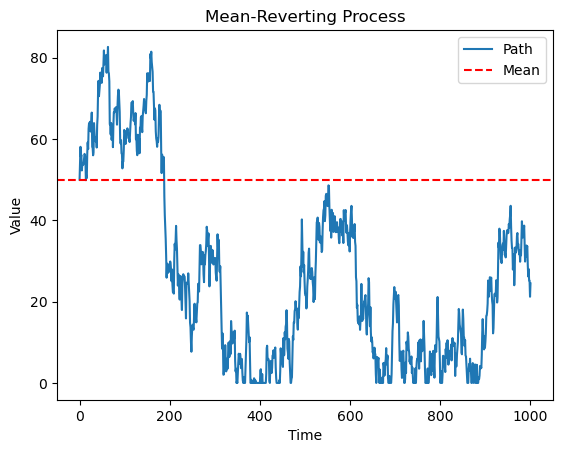

In [3]:
a = 0
b = 100
c = np.random.uniform(a, b)
mean_revert = (b - a) / c

path = []
current_value = (a + b) / 2 
path.append(current_value)

for i in range(1000):
    movement = np.random.normal(0, 1) * mean_revert
    current_value += movement
    current_value = max(a, min(b, current_value))
    path.append(current_value)

plt.plot(path, label='Path')

plt.axhline(y=(a+b) / 2, color='r', linestyle='--', label='Mean')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Mean-Reverting Process')
plt.show()


2. Simulate a Cox-Ingersoll-Ross (CIR) process
$$
dX_t = (6 - 2X_t)dt + θ\sqrt{X_t}dW_t, X(0)=1,
$$
where $θ = θ_1 = 1$ for $t < τ_0 = 0.6$ and $θ = θ_2$ for $t ≥ τ_0$, $t \in (0, 1)$.

Plot the simulated path, plot the shape of statistic $|\hat{D}_k|$ and
identify the change-point $k_0$ on a time-serie and compare result with $\tau_0$.

**Hint (Iacus, 2008, p. 212).** Consider the $\sigma(x)$ is constant and $b(x)$ can be estimated
$$
\hat{b}_n(x) = \frac{\sum_{i=0}^{n-1} K\left(\frac{x-X_i}{h_n}\right)(X_{i+1}-X_i)} {\Delta_n \sum_{i=0}^{n-1} K\left(\frac{x-X_i}{h_n}\right)},
$$
then use residuals
$$
Z_i = \frac{(X_{i+1} - X_i) - \hat{b}(X_i)\Delta_n}{\sqrt{\Delta_n}},
$$
and compute the statistic
$$
\hat{V}_k = \left(\frac{k(n-k)}{n^2}\right)^{1/2} \left(\frac{\hat{S}_{n-k}}{n-k}
- \frac{\hat{S}_k}{k}\right)
 = \frac{\hat{S}_n \hat{D}_k}{\sqrt{n-k}},
$$
where
$\hat{S}_k = \sum_{i=1}^k \hat{Z}_i^2$,
$\hat{S}_{n-k} = \sum_{i=k+1}^n \hat{Z}_i^2$, and $\hat{D}_k = \frac kn - \frac{\hat{S}_k}{\hat{S}_n}.$

Finally the change-point is identifed as the solution to
$$
\hat{k}_0 = \arg \min_k |\hat{D}_k|.
$$

Expected result is:

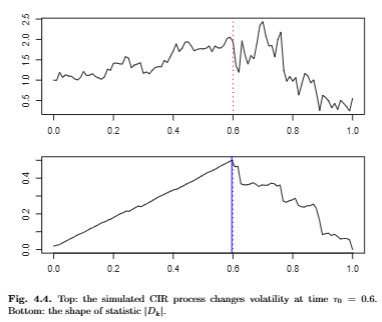

https://forecastegy.com/posts/change-point-detection-time-series-python/

https://github.com/amanahuja/change-detection-tutorial

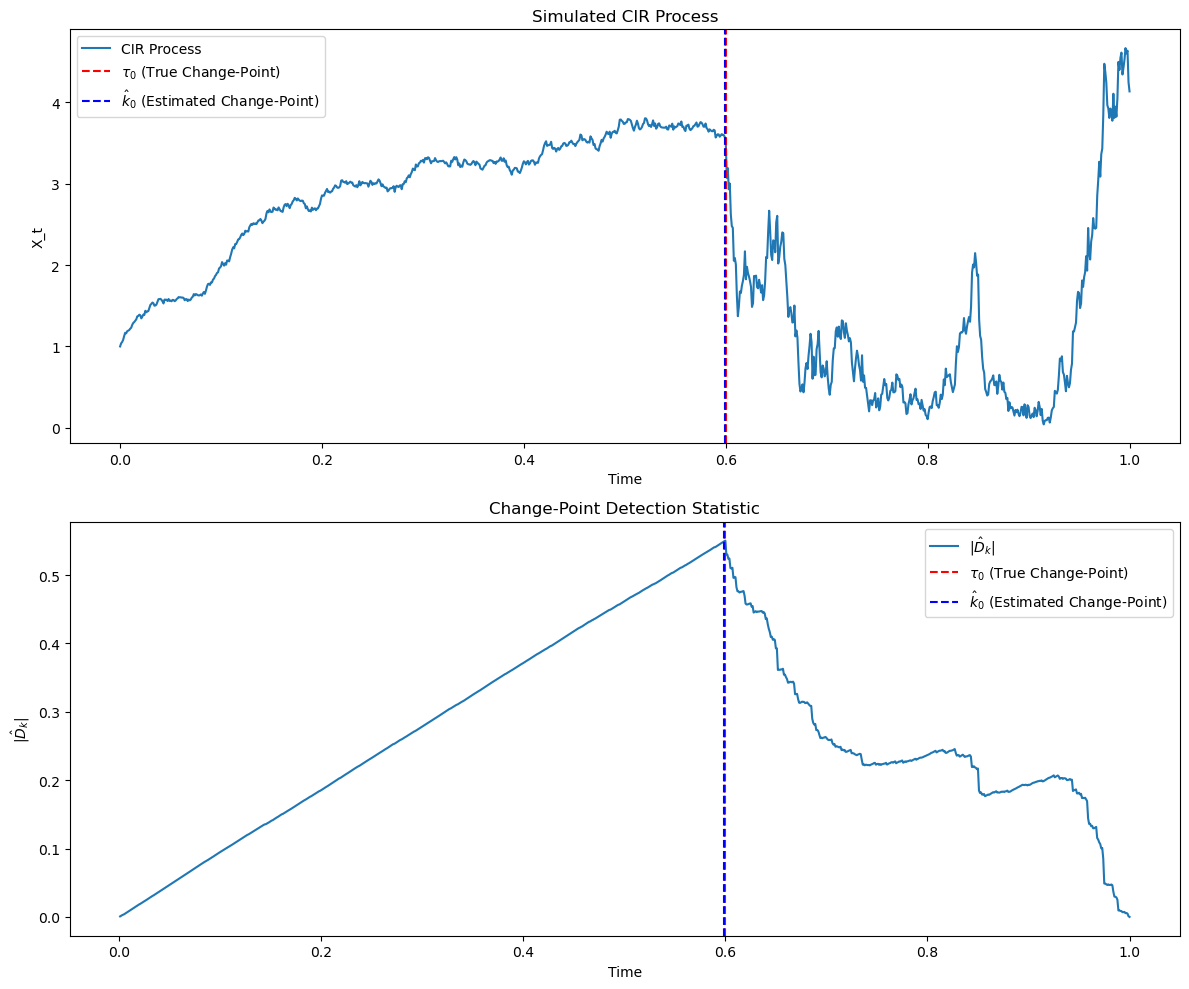

(0.6, 0.599)

In [4]:
volatility_before = 0.5  
volatility_after = 5    
mean_reversion_speed = 2.0  
mean_level = 6.0         
initial_value = 1.0      
change_point = 0.6       
total_time = 1.0        
time_step = 0.001        

num_steps = int(total_time / time_step)

time_vector = np.linspace(0, total_time, num_steps + 1)

process_values = np.zeros(num_steps + 1)
process_values[0] = initial_value
np.random.seed(0)

for step in range(1, num_steps + 1):
    current_volatility = volatility_before if time_vector[step] < change_point else volatility_after
    random_increment = np.sqrt(time_step)*  np.random.normal()
    process_values[step] = (process_values[step - 1] + 
                            mean_reversion_speed* (mean_level - process_values[step - 1])  *time_step + 
                            current_volatility * np.sqrt(max(process_values[step - 1], 0))*  random_increment)

bandwidth = 0.1  
residuals = np.zeros(num_steps)

for step in range(num_steps):
    kernel_weights = np.exp(-((process_values[step] - process_values[:num_steps]) / bandwidth)**  2)
    b_hat = np.sum(kernel_weights *(process_values[1:num_steps + 1] - process_values[:num_steps])) / (time_step *  np.sum(kernel_weights))
    residuals[step] = (process_values[step + 1] - process_values[step] - b_hat*  time_step) / np.sqrt(time_step)

cumulative_sum = np.cumsum(residuals**2)
detection_statistic = (np.arange(1, num_steps + 1) / num_steps) - (cumulative_sum / cumulative_sum[-1])
absolute_detection_statistic = np.abs(detection_statistic)

estimated_change_point = np.argmax(absolute_detection_statistic)

fig, axes = plt.subplots(2, 1, figsize=(12, 10))

axes[0].plot(time_vector, process_values, label="CIR Process")
axes[0].axvline(change_point, color="red", linestyle="--", label=r"$\tau_0$ (True Change-Point)")
axes[0].axvline(time_vector[estimated_change_point], color="blue", linestyle="--", label=r"$\hat{k}_0$ (Estimated Change-Point)")
axes[0].set_xlabel("Time")
axes[0].set_ylabel("X_t")
axes[0].legend()
axes[0].set_title("Simulated CIR Process")

axes[1].plot(time_vector[1:], absolute_detection_statistic, label=r"$|\hat{D}_k|$")
axes[1].axvline(change_point, color="red", linestyle="--", label=r"$\tau_0$ (True Change-Point)")
axes[1].axvline(time_vector[estimated_change_point], color="blue", linestyle="--", label=r"$\hat{k}_0$ (Estimated Change-Point)")
axes[1].set_xlabel("Time")
axes[1].set_ylabel(r"$|\hat{D}_k|$")
axes[1].legend()
axes[1].set_title("Change-Point Detection Statistic")

plt.tight_layout()
plt.show()

change_point, time_vector[estimated_change_point]

3. Simulate and plot 100 trajectories of the process
$$
dX_t = (0.03tX_t – X^3_t)dt + 0.1dW_t
$$
with the 1st Milstein scheme, $x_0=0$, $t_0=0$, $T=100$, and $\Delta t=0.01$.

Add an average trajectory and confidence interval on the graph.

In [4]:
class StochasticProcess:
    def __init__(self, params, T, Nx, Nt, init_state = None):
        self.params = params
        self.T = T
        self.Nx = Nx # Number of trajectories
        self.Nt = Nt # Number of discretization steps
        self.init_state = init_state

        #Wiener Process by default
        self.bxt = lambda x: 0
        self.sigmaxt = lambda x: 1
        self.bxt_x = lambda x: 0
        self.bxt_xx = lambda x: 0
        self.sigmaxt_x = lambda x: 0
        self.sigmaxt_xx = lambda x: 0

    def DefaultInitState(self):
        return np.zeros(self.Nx)

    def SampleFromDensity(self, x0, t, t0):
        result = np.zeros(self.Nx)
        for k in range(0, self.Nx):
            result[k] = x0[k] + np.random.normal(0, 1) * np.sqrt(t - t0)
        return result

    def PathGenerator(self):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        for i in range(1, self.Nt + 1):
            x_data[i] = self.SampleFromDensity(x_data[i - 1], t_data[i], t_data[i - 1])
        return t_data, x_data

    def ExactSolution(self, dwt):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        for i in range(1, self.Nt + 1):
            x_data[i] = x_data[i - 1] + dwt[i - 1]
        return t_data, x_data

    def EulerSolution(self, dwt):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        for i in range(1, self.Nt + 1):
            x_data[i] = x_data[i - 1] + self.bxt(x_data[i - 1]) * dt + self.sigmaxt(x_data[i - 1]) * dwt[i - 1]
        return t_data, x_data

    def Milstein1Solution(self, dwt):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        for i in range(1, self.Nt + 1):
            x_data[i] = x_data[i - 1] + self.bxt(x_data[i - 1]) * dt + self.sigmaxt(x_data[i - 1]) * dwt[i - 1] + \
                        1/2 * self.sigmaxt(x_data[i - 1]) * self.sigmaxt_x(x_data[i - 1]) * (dwt[i - 1]**2 - dt)
        return t_data, x_data

    def Milstein2Solution(self, dwt):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        for i in range(1, self.Nt + 1):
            x_data[i] = x_data[i - 1] + (self.bxt(x_data[i - 1]) - 1/2 * self.sigmaxt(x_data[i - 1]) * self.sigmaxt_x(x_data[i - 1])) * dt +\
                        self.sigmaxt(x_data[i - 1]) * dwt[i - 1] + 1/2 * self.sigmaxt(x_data[i - 1]) * self.sigmaxt_x(x_data[i - 1]) * dwt[i - 1]**2 +\
                        (1/2 * self.bxt(x_data[i - 1]) * self.sigmaxt_x(x_data[i - 1]) + 1/2 * self.bxt_x(x_data[i - 1]) * self.sigmaxt(x_data[i - 1]) +\
                        1/4 * self.sigmaxt(x_data[i - 1])**2 * self.sigmaxt_xx(x_data[i - 1])) * dt * dwt[i - 1] +\
                        (1/2 * self.bxt(x_data[i - 1]) * self.bxt_x(x_data[i - 1]) + 1/4 * self.bxt_xx(x_data[i - 1]) * self.sigmaxt(x_data[i - 1])**2) * dt**2
        return t_data, x_data

    def PredictorCorrectorSolution(self, dwt, eta = 1/2, alpha = 1/2):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        for i in range(1, self.Nt + 1):
            yw = x_data[i - 1] + self.bxt(x_data[i - 1]) * dt + self.sigmaxt(x_data[i - 1]) * dwt[i - 1]
            bwim1 = self.bxt(x_data[i - 1]) - eta * self.sigmaxt(x_data[i - 1]) * self.sigmaxt_x(x_data[i - 1])
            bwi = self.bxt(yw) - eta * self.sigmaxt(yw) * self.sigmaxt_x(yw)
            x_data[i] = x_data[i - 1] + alpha * bwi * dt + (1 - alpha) * bwim1 * dt +\
                        eta * self.sigmaxt(yw) * dwt[i - 1] + (1 - eta) * self.sigmaxt(x_data[i - 1]) * dwt[i - 1]
        return t_data, x_data


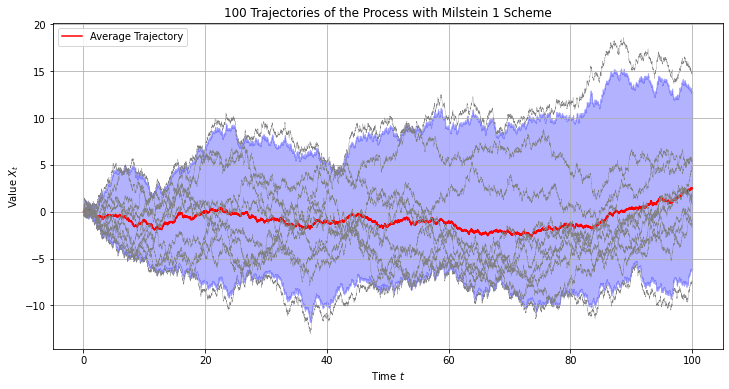

In [5]:
class Process(StochasticProcess):
    def init(self, params, T, Nx, Nt, init_state=0):
        super().init(params, T, Nx, Nt, init_state)
                     
    def bxt(self, x):
        return 0.03 * t * x - x ** 3

    def sigmaxt(self, x):
        return 0.1

    def sigmaxt_x(self, x):
        return 0

T = 100
Nx = 10
Nt = T / 0.01

process_ = Process({}, T, Nx, int(Nt))

t_data, x_data = process_.Milstein1Solution(np.random.normal(0, np.sqrt(process_.T/process_.Nt), (int(process_.Nt), Nx)))

average_trajectory = np.mean(x_data, axis=1)
lower_bound = np.percentile(x_data, 2.5, axis=1)
upper_bound = np.percentile(x_data, 97.5, axis=1)

plt.figure(figsize=(12, 6))
plt.plot(t_data, average_trajectory, label='Average Trajectory', color='red')
plt.fill_between(t_data, lower_bound, upper_bound, alpha=0.3, color='blue')

for i in range(Nx):
    plt.plot(t_data, x_data[:, i], linewidth=0.3, color='gray')

plt.xlabel('Time $t$')
plt.ylabel('Value $X_t$')
plt.title('100 Trajectories of the Process with Milstein 1 Scheme')
plt.legend()
plt.grid(True)
plt.show()

4. Implement a non-parametric drift and diffusion estimators for the Ornstein-Uhlenbeck model
$$
dX_t = (θ_1 - θ_2X_t)dt + θ_3 dW_t,
X(0) = 10,  θ = (0, 3, 2).
$$

Use
*   uniform kernel $K(u) = 1/2$,
*   Epanechnikov (parabolic) kernel $K(u) = \frac{3}{4}(1 - u^2)$,
*   Gaussian kernel $K(u) = \frac{1}{\sqrt{2\pi}} \exp \left(-\frac{1}{2}u^2\right)$,

and plot the estimations on the graph.


In [6]:
param_theta = (0, 3, 2) 
initial_state = 10     
total_time = 1.0        
num_steps = 1000        
time_step = total_time / num_steps
time_values = np.linspace(0, total_time, num_steps + 1)

In [7]:
process_values = np.zeros(num_steps + 1)
process_values[0] = initial_state

In [8]:
for i in range(1, num_steps + 1):
    dW = np.random.normal(0, np.sqrt(time_step))
    process_values[i] = process_values[i - 1] + (param_theta[0] - param_theta[1] * process_values[i - 1]) * time_step + param_theta[2] * dW

In [9]:
def uniform_kernel(u):
    return 0.5 * np.where(np.abs(u) <= 1, 1, 0)

def epanechnikov_kernel(u):
    return 0.75 * (1 - u**2) * np.where(np.abs(u) <= 1, 1, 0)

def gaussian_kernel(u):
    return (1 / np.sqrt(2 * np.pi)) * np.exp(-0.5 * u**2)

In [10]:
def non_parametric_estimators(data, time_step, h_value, kernel_func):

    dX = data[1:] - data[:-1]
    X_mid = data[:-1]  
    x_min, x_max = X_mid.min() - 1, X_mid.max() + 1
    x_grid = np.linspace(x_min, x_max, 500)

    b_est = np.zeros_like(x_grid)
    a_est = np.zeros_like(x_grid)

    for i, x in enumerate(x_grid):
        u_values = (X_mid - x) / h_value
        K_values = kernel_func(u_values)
        numerator_b = np.sum(K_values * dX) / time_step
        denominator = np.sum(K_values)
        b_est[i] = numerator_b / denominator if denominator != 0 else 0

        numerator_a = np.sum(K_values * dX**2) / time_step
        a_est[i] = numerator_a / denominator if denominator != 0 else 0

    return x_grid, b_est, a_est


In [11]:
def calculate_bandwidth(data):
    std_deviation = np.std(data)
    data_length = len(data)
    return 1.06 * std_deviation * data_length ** (-1 / 5)

In [12]:
bandwidth_uniform = calculate_bandwidth(process_values)
bandwidth_epanechnikov = calculate_bandwidth(process_values)
bandwidth_gaussian = calculate_bandwidth(process_values)

In [13]:
x_grid_uniform, b_est_uniform, a_est_uniform = non_parametric_estimators(process_values, time_step, bandwidth_uniform, uniform_kernel)
x_grid_epanechnikov, b_est_epanechnikov, a_est_epanechnikov = non_parametric_estimators(process_values, time_step, bandwidth_epanechnikov, epanechnikov_kernel)
x_grid_gaussian, b_est_gaussian, a_est_gaussian = non_parametric_estimators(process_values, time_step, bandwidth_gaussian, gaussian_kernel)

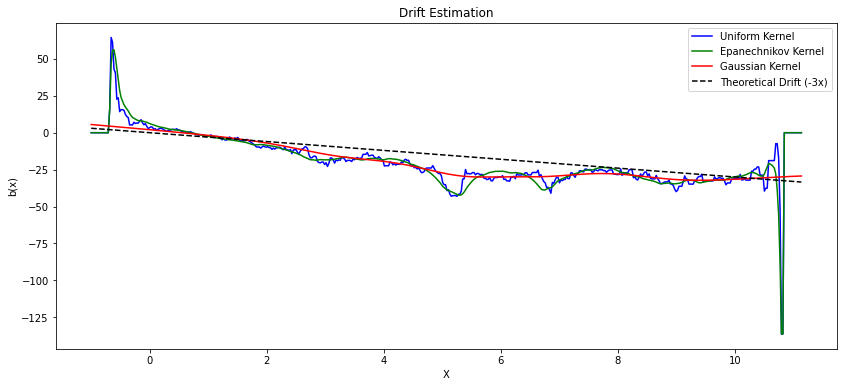

In [14]:
def theoretical_drift(x):
    return param_theta[0] - param_theta[1] * x  # -3x

def theoretical_diffusion(x):
    return param_theta[2] ** 2  # 4

plt.figure(figsize=(14, 6))
plt.plot(x_grid_uniform, b_est_uniform, label='Uniform Kernel', color='blue')
plt.plot(x_grid_epanechnikov, b_est_epanechnikov, label='Epanechnikov Kernel', color='green')
plt.plot(x_grid_gaussian, b_est_gaussian, label='Gaussian Kernel', color='red')
plt.plot(x_grid_uniform, theoretical_drift(x_grid_uniform), label='Theoretical Drift (-3x)', color='black', linestyle='--')
plt.title('Drift Estimation')
plt.xlabel('X')
plt.ylabel('b(x)')
plt.legend()


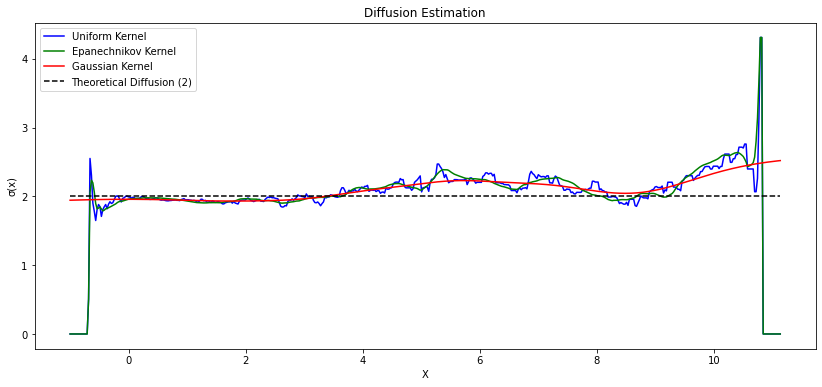

In [15]:

plt.figure(figsize=(14, 6))
plt.plot(x_grid_uniform, np.sqrt(a_est_uniform), label='Uniform Kernel', color='blue')
plt.plot(x_grid_epanechnikov, np.sqrt(a_est_epanechnikov), label='Epanechnikov Kernel', color='green')
plt.plot(x_grid_gaussian, np.sqrt(a_est_gaussian), label='Gaussian Kernel', color='red')
plt.plot(x_grid_uniform, np.sqrt(theoretical_diffusion(x_grid_uniform)) * np.ones_like(x_grid_uniform), 
         label='Theoretical Diffusion (2)', color='black', linestyle='--')
plt.title('Diffusion Estimation')
plt.xlabel('X')
plt.ylabel('σ(x)')
plt.legend()

plt.show()

5. Estimate the parameters of a random process. As candidates use
*   Ornstein-Uhlenbeck process,
*   Geometric Brownian motion process,
*   Cox-Ingersoll-Ross process.

Plot three models in a graph and choose the best one. Provide the proof of your solution.

Time-series (*. csv) in the [folder](https://drive.google.com/drive/folders/1tzHl3-7jMtRiGgFe5suqT2CzftZ0o9cB?usp=sharing).

In [24]:

class StochasticProcess:
    def __init__(self, params, T, Nx, Nt, init_state = None):
        self.params = params
        self.T = T
        self.Nx = Nx
        self.Nt = Nt
        self.init_state = init_state

        #Wiener Process by default
        self.bxt = lambda x: 0
        self.sigmaxt = lambda x: 1

    def sampler_init_state(self):
        return np.zeros(self.Nx)

    def EulerSolution(self):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, round(Nt + 1))
        x_data = np.zeros((round(self.Nt + 1), self.Nx))

        if self.init_state is None:
            x_data[0] = self.sampler_init_state()
        else:
            x_data[0] = self.init_state

        for i in range(1, self.Nt + 1):
            dwt = np.random.normal(0, 1, size = self.Nx) * np.sqrt(dt)
            x_data[i] = x_data[i - 1] + self.bxt(x_data[i - 1]) * dt + self.sigmaxt(x_data[i - 1]) * dwt
        return t_data, x_data

class OrnsteinUhlenbeckProcess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state = None):
        super().__init__(params, T, Nx, Nt, init_state)

        # params = [theta, mu, sigma]
        self.bxt = lambda x: self.params[0] * (self.params[1] - x)
        self.sigmaxt = lambda x: self.params[2]

    def sampler_init_state(self):
        return self.params[1] * np.ones(self.Nx)


class CoxIngersollRossProcess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state = None):
        super().__init__(params, T, Nx, Nt, init_state)

        # params = [theta1, theta2, theta3]
        self.bxt = lambda x: self.params[0] - self.params[1] * x
        self.sigmaxt = lambda x: self.params[2] * np.sqrt(np.maximum(x, 0))

    def sampler_init_state(self):
        return self.params[0] / self.params[1] * np.ones(self.Nx)


class BlackScholesMertonProcess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state = None):
        super().__init__(params, T, Nx, Nt, init_state)

        # params = [theta1, theta2]
        self.bxt = lambda x: self.params[0] * x
        self.sigmaxt = lambda x: self.params[1] * x

    def sampler_init_state(self):
        return self.params[0] * np.ones(self.Nx)

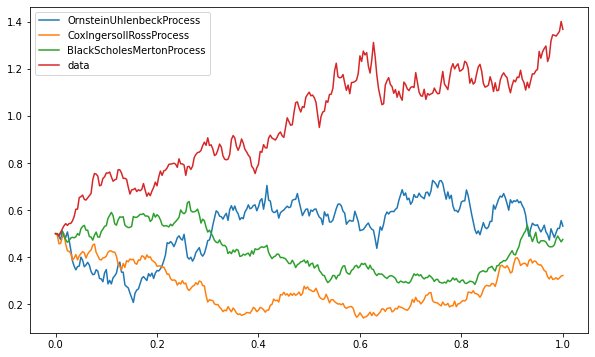

Best Process: OrnsteinUhlenbeckProcess
Parameters: [0.09999517 0.49999927 0.39999858]


In [27]:


def objective_function(params, data, process):
    t_data = data.iloc[:, 0].values
    x_data = data.iloc[:, 1].values
    T = process.T
    Nx = process.Nx
    Nt = process.Nt

    process.params = params

    t_sim, x_sim = process.EulerSolution()

    mse = np.mean((x_sim - x_data)**2)

    return mse

data = pd.read_csv('7.csv')

processes = [
OrnsteinUhlenbeckProcess(params=[0.1, 0.5, 0.4], T=1, Nx=1, Nt=300),
CoxIngersollRossProcess(params=[0.25, 0.5, 0.4], T=1, Nx=1, Nt=300),
BlackScholesMertonProcess(params=[0.5, 0.5], T=1, Nx=1, Nt=300)
]

for process in processes:
    result = minimize(objective_function, process.params, args=(data, process))
    process.params = result.x
plt.figure(figsize=(10, 6))
for process in processes:
    
    t_sim, x_sim = process.EulerSolution()
    plt.plot(data.iloc[:, 0].values, x_sim, label=process.__class__.__name__)
    #plt.plot(t_sim, x_data, 'o')
plt.plot(data.iloc[:, 0].values, data.iloc[:, 1].values, label='data')
plt.legend()
plt.show()

mse_list = [objective_function(process.params, data, process) for process in processes]
best_process = processes[np.argmin(mse_list)]

print('Best Process:', best_process.__class__.__name__)
print('Parameters:', best_process.params)